# Test Linear Lifting
The goal here is to verify that we are able to learn linearizing maps. As such, we play around below in the situation where there is an underlying LDS with some nonlinear observations. We are interested in checking whether we are able to reproduce the underlying LDS.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS
from extravaganza.sysid import Lifter
from extravaganza.utils import summarize_lds, sample, jkey

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpxy2bppjk
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpxy2bppjk/_remote_module_non_scriptable.py


In [2]:
def obs_func(x):
    return jnp.sign(x) * (jnp.abs(x) ** 0.5)   # looks sorta sigmoidal

# make g.t. linear system
du = 2  # control dim
ds = 4  # state dim
system = LDS(ds, du, 'none', 'quad', seed=SYSTEM_SEED)
A, B = system.A, system.B
print(summarize_lds(A, B))

# make sysid
T0 = 20000
dl = 4

sysid_args = {
    'obs_dim': ds,
    'control_dim': du,

    'max_traj_len': int(1e6),
    'exploration_scale': 1.,

    'sigma': 0.01,
    'determinstic_encoder': True,
    'depth': 6,
    'num_epochs': 500,
    'batch_size': 256,
    'lifter_lr': 0.004,
    'sysid_lr': 0.0015,

    'seed': SYSID_SEED,
}
sysid = Lifter(method='nn', state_dim=dl, **sysid_args)

# interaction loop
control = jnp.zeros(du)
for _ in tqdm.trange(T0):
    cost, state = system.interact(control)
    obs = obs_func(state)
    control = sysid.explore(cost, obs)
Ahat, Bhat = sysid.end_exploration(wordy=True)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (LDS) for the LDS we are !!!NOT!!! reporting the costs with the `u.T @ R @ u` part
INFO: (LDS): initial state is [-0.25565735 -0.41134962  0.74716395 -2.1830933 ]


||A||_op = 0.9246821999549866
||B||_F = 1.165912389755249
||A-BK||_op = 0.5761350393295288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3900.61it/s]
INFO: (LIFTER): ending sysid phase at step 20000
INFO: training!
INFO: mean loss for epochs -25 - 0 was {'linearization': 0.0056873940226908485, 'cpc': 0.9984652912005398, 'consistency': 0.0, 'simplification': 28.752586083534446, 'residual centeredness': 3.822501718075681e-05, 'centeredness': 3.432709209811993}
INFO: mean loss for epochs 0 - 25 was {'linearization': 0.8658411916574607, 'cpc': 0.9435732091084504, 'consistency': 0.0, 'simplification': 4.890975143542656, 'residual centeredness': 0.013126419045690388, 'centeredness': 1.990940450139535}
INFO: mean loss for epochs 25 - 50 was {'linearization': 1.3808970970068222, 'cpc': 0.9679163798613425, 'consistency': 0.0, 'simplification': 1.638705971837044, 'residual centeredness': 0.01800610780495052, 'centeredness': 0.8654202251709424}
INFO: mean loss for epochs 50 - 75 was {'linearizati

||A||_op = 0.9232118725776672
||B||_F = 1.202485203742981
||A-BK||_op = 0.5788575410842896


In [55]:
# to see how well we did, we check the following things
def Fhat(y): return sysid.get_state(y)
g = obs_func

# make dataset of x's and u's
N = 500
xs, us = [], []
system.reset()
for _ in range(N):
    control = sample(jkey(), (du,)) * sysid_args['exploration_scale']
    cost, state = system.interact(control)
    xs.append(state)
    us.append(control)
    
# this evaluates model's understanding of the effect of control
b_loss = np.median([jnp.linalg.norm(Fhat(g(B @ u)) - Bhat @ u) ** 2 / (jnp.linalg.norm(u) ** 2) for u in us])

# this evalutes model's understanding of passive dynamics
a_loss = np.median([jnp.linalg.norm(Fhat(g(A @ x)) - Ahat @ Fhat(g(x))) ** 2 / (jnp.linalg.norm(x) ** 2) for x in xs])

# this evaluates model's understanding of cost
norm_loss = np.median([abs(jnp.linalg.norm(x) ** 2 - jnp.linalg.norm(Fhat(g(x))) ** 2) / (jnp.linalg.norm(x) ** 2) for x in xs])

print(a_loss, b_loss, norm_loss)

0.0021714128 0.0033128601 0.026838968


In [84]:
# check how well we do at prediction
x = sample(jkey(), (ds,))
s = sysid.get_state(obs_func(x))
original = s.copy()
for _ in range(1):
    u = sample(jkey(), (du,))
    x = A @ x + B @ u
    s = Ahat @ s + Bhat @ u
gt = sysid.get_state(obs_func(x))
pred = s.copy()
print(jnp.linalg.norm(gt - original), jnp.linalg.norm(pred - original), jnp.linalg.norm(gt - pred))

1.7192662 1.6934311 0.28317678


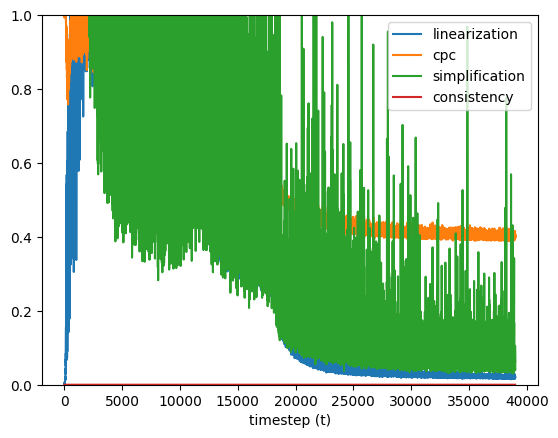

In [85]:
from extravaganza.utils import ylim
fig, ax = plt.subplots(1, 1)
for k in ['linearization', 
          'cpc', 
          'simplification', 
          'consistency']:
    sysid.stats.plot(ax, k, label=k)
ax.legend()
ylim(ax, 0, 1)
plt.show()